<a href="https://colab.research.google.com/github/rafllpiresc/Trabalho-Machine-Learning/blob/main/Trabalho_final_Rafael_Canuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho Final

In [ ]:
!pip install q keras==2.12.0
!pip install bayesian-optimization
!pip install h2o
!pip install catboost

##1. Base de Dados

In [ ]:
import pandas as pd
import math, warnings, sys, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from io import StringIO
import h2o
from h2o.automl import H2OAutoML
from catboost import CatBoostClassifier

In [ ]:
drive.mount('/content/drive', force_remount=True)

%cd '/content/drive/MyDrive/MachineLearning_01_2024/Trabalho_final'

Mounted at /content/drive
/content/drive/MyDrive/MachineLearning_01_2024/Trabalho_final


In [ ]:
# Carregar os dados
df = pd.read_csv("train_churn.csv", sep=';')

In [ ]:
# Visualizar as primeiras linhas dos dados
df.head()

,Unnamed: 0,genero,idoso,parceiro,dependentes,tempoDeServico,ServicoTelefone,MultiLinhas,ServicoInternet,ServicoSegurancaCyber,...,StreamingTV,StreamingFilmes,Contrato,BillingDigital,MetodoPagamento,FaturaMensal,FaturaTotal,NumTickets,NumTicketsTecnico,Churn
0,6027,Masculino,0.0,Sim,Sim,35.0,Sim,Sim,Não,Sem serviço de internet,...,Sem serviço de internet,Sem serviço de internet,2 Anos,Não,Transferência Bancária (Automática),25.45,809.25,0.0,0.0,0.0
1,1961,Feminino,0.0,Não,Não,42.0,Sim,Sim,DSL,NaN,...,Não,Não,1 Ano,Sim,Transferência Bancária (Automática),60.15,2421.6,0.0,0.0,0.0
2,5308,Feminino,0.0,Não,Não,69.0,Sim,Não,DSL,Sim,...,Sim,Sim,2 Anos,Sim,Cartão de Crédito (Automático),82.45,5555.3,0.0,0.0,0.0
3,3587,Masculino,1.0,Não,Não,9.0,Sim,NaN,Fibra óptica,Não,...,Sim,Sim,Mensal,Sim,Cartão de Crédito (Automático),99.45,919.4,0.0,0.0,1.0
4,576,Masculino,0.0,Sim,Sim,31.0,Sim,Sim,Fibra óptica,Sim,...,Sim,Não,1 Ano,Não,Transferência Bancária (Automática),98.05,3082.1,NaN,0.0,0.0


In [ ]:
# Verificar informações sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5000 non-null   int64  
 1   genero                 4759 non-null   object 
 2   idoso                  4735 non-null   float64
 3   parceiro               4762 non-null   object 
 4   dependentes            4766 non-null   object 
 5   tempoDeServico         4747 non-null   float64
 6   ServicoTelefone        4789 non-null   object 
 7   MultiLinhas            4745 non-null   object 
 8   ServicoInternet        4771 non-null   object 
 9   ServicoSegurancaCyber  4778 non-null   object 
 10  ServicoBackup          4737 non-null   object 
 11  SeguroDispositivos     4750 non-null   object 
 12  ServicoSuporteTecnico  4767 non-null   object 
 13  StreamingTV            4751 non-null   object 
 14  StreamingFilmes        4775 non-null   object 
 15  Cont

In [ ]:
# Estatísticas descritivas
df.describe()

,Unnamed: 0,idoso,tempoDeServico,FaturaMensal,NumTickets,NumTicketsTecnico,Churn
count,5000.000000,4735.000000,4747.000000,4726.000000,4731.000000,4745.000000,4736.000000
mean,3514.527800,0.163464,32.158205,64.801947,0.503488,0.411170,0.263091
std,2019.383889,0.369827,29.592578,35.930051,1.260113,1.230994,0.440358
min,0.000000,0.000000,-112.000000,-127.000000,0.000000,0.000000,0.000000
25%,1779.500000,0.000000,8.000000,34.700000,0.000000,0.000000,0.000000
50%,3494.500000,0.000000,29.000000,70.400000,0.000000,0.000000,0.000000
75%,5263.250000,0.000000,56.000000,90.400000,0.000000,0.000000,1.000000
max,7042.000000,1.000000,190.000000,247.000000,5.000000,8.000000,1.000000


##2. Tratamento dos Dados

###Limpeza

In [ ]:
# Apagando valores vazios de churn
df.dropna(subset=['Churn'], inplace=True)

# Substituindo os nans da coluna 'genero' por 'Outros'
df['genero'].fillna('Outros', inplace=True)

# Mapeamento para verificar se o registro de ausência de internet pode ser substituído pelo valor presente em outra coluna
# Lista das colunas que precisam ser verificadas e corrigidas
colunas_sem_internet = ['ServicoSegurancaCyber', 'ServicoBackup', 'SeguroDispositivos', 'ServicoSuporteTecnico', 'StreamingTV', 'StreamingFilmes']

# Condições para substituição
condicao_nan = df[colunas_sem_internet].isna().any(axis=1)
condicao_sem_servico = (df['ServicoInternet'] == 'Sem serviço de internet') | (df[colunas_sem_internet] == 'Sem serviço de internet').any(axis=1)
condicao_servico_nao = df['ServicoInternet'] == 'Não'

# Substituir NaN por 'Não' se houver registro de 'Não' em ServicoInternet ou Sem serviço de internet em alguma das colunas mencionadas
df.loc[condicao_nan & (condicao_sem_servico | condicao_servico_nao), colunas_sem_internet] = 'Não'

# Substituir NaN por 'Sem serviço de internet' se não houver registro de 'Não' em ServicoInternet ou Sem serviço de internet em alguma das colunas mencionadas
df.loc[condicao_nan & ~(condicao_sem_servico | condicao_servico_nao), colunas_sem_internet] = 'Sem serviço de internet'

# Mapeamento para verificar se o registro de ausência de serviço de telefone pode ser substituído pelo valor presente em outra coluna
# Substituir NaN em MultiLinhas por 'Sem serviço de telefone' se ServicoTelefone for 'Não'
condicao_ServicoTelefone = (df['ServicoTelefone'] == 'Não') & (df['MultiLinhas'].isna())
df.loc[condicao_ServicoTelefone, 'MultiLinhas'] = 'Sem serviço de telefone'

# Substituir NaN em ServicoTelefone por 'Não' se MultiLinhas for 'Sem serviço de telefone'
condicao_MultiLinhas = (df['MultiLinhas'] == 'Sem serviço de telefone') & (df['ServicoTelefone'].isna())
df.loc[condicao_MultiLinhas, 'ServicoTelefone'] = 'Não'

# Calculando a moda das colunas booleanas
moda_idoso = df['idoso'].mode()[0]
moda_parceiro = df['parceiro'].mode()[0]
moda_dependentes = df['dependentes'].mode()[0]
moda_ServicoTelefone = df['ServicoTelefone'].mode()[0]
moda_BillingDigital = df['BillingDigital'].mode()[0]
moda_MultiLinhas = df['MultiLinhas'].mode()[0]
moda_ServicoInternet = df['ServicoInternet'].mode()[0]
moda_ServicoSegurancaCyber = df['ServicoSegurancaCyber'].mode()[0]
moda_ServicoBackup = df['ServicoBackup'].mode()[0]
moda_SeguroDispositivos = df['SeguroDispositivos'].mode()[0]
moda_ServicoSuporteTecnico = df['ServicoSuporteTecnico'].mode()[0]
moda_StreamingTV = df['StreamingTV'].mode()[0]
moda_StreamingFilmes = df['StreamingFilmes'].mode()[0]
moda_Contrato = df['Contrato'].mode()[0]
moda_BillingDigital = df['BillingDigital'].mode()[0]
moda_MetodoPagamento = df['MetodoPagamento'].mode()[0]
moda_NumTickets = df['NumTickets'].mode()[0]
moda_NumTicketsTecnico = df['NumTicketsTecnico'].mode()[0]

# Preenchendo os valores NaN com a respectiva moda
df['idoso'].fillna(moda_idoso, inplace=True)
df['parceiro'].fillna(moda_parceiro, inplace=True)
df['dependentes'].fillna(moda_dependentes, inplace=True)
df['ServicoTelefone'].fillna(moda_ServicoTelefone, inplace=True)
df['BillingDigital'].fillna(moda_BillingDigital, inplace=True)
df['MultiLinhas'].fillna(moda_MultiLinhas, inplace=True)
df['ServicoInternet'].fillna(moda_ServicoInternet, inplace=True)
df['ServicoSegurancaCyber'].fillna(moda_ServicoSegurancaCyber, inplace=True)
df['ServicoBackup'].fillna(moda_ServicoBackup, inplace=True)
df['SeguroDispositivos'].fillna(moda_SeguroDispositivos, inplace=True)
df['ServicoSuporteTecnico'].fillna(moda_ServicoSuporteTecnico, inplace=True)
df['StreamingTV'].fillna(moda_StreamingTV, inplace=True)
df['StreamingFilmes'].fillna(moda_StreamingFilmes, inplace=True)
df['Contrato'].fillna(moda_Contrato, inplace=True)
df['BillingDigital'].fillna(moda_BillingDigital, inplace=True)
df['MetodoPagamento'].fillna(moda_MetodoPagamento, inplace=True)
df['NumTickets'].fillna(moda_NumTicketsTecnico, inplace=True)
df['NumTicketsTecnico'].fillna(moda_NumTickets, inplace=True)

# Substituindo os valores binário de 'Sim' e 'Não' por 1 e 0
# Mapeamento de 'Sim' para 1 e 'Não' para 0
mapeamento_sim_nao = {'Sim': 1, 'Não': 0}

# Lista das colunas a serem transformadas
colunas_a_transformar = ['idoso', 'parceiro', 'dependentes', 'ServicoTelefone', 'BillingDigital', 'Churn']

# Aplicar o mapeamento de dicionário para cada coluna
for coluna in colunas_a_transformar:
    # Substituir os valores 'Sim' e 'Não' pelo mapeamento
    df[coluna].replace(mapeamento_sim_nao, inplace=True)

    # Converter a coluna para o tipo de dados inteiro
    df[coluna] = df[coluna].astype(int)

In [ ]:
for column in ['genero','parceiro','dependentes','ServicoTelefone','MultiLinhas','ServicoInternet','ServicoSegurancaCyber','SeguroDispositivos','ServicoSuporteTecnico','StreamingTV','StreamingFilmes','Contrato','MetodoPagamento','Churn']:
  print(f'coluna: {column}: {df[column].unique()}')

coluna: genero: ['Masculino' 'Feminino' 'Outros']
coluna: parceiro: [1 0]
coluna: dependentes: [1 0]
coluna: ServicoTelefone: [1 0]
coluna: MultiLinhas: ['Sim' 'Não' 'Sem serviço de telefone']
coluna: ServicoInternet: ['Não' 'DSL' 'Fibra óptica']
coluna: ServicoSegurancaCyber: ['Sem serviço de internet' 'Sim' 'Não']
coluna: SeguroDispositivos: ['Sem serviço de internet' 'Sim' 'Não']
coluna: ServicoSuporteTecnico: ['Sem serviço de internet' 'Sim' 'Não']
coluna: StreamingTV: ['Sem serviço de internet' 'Sim' 'Não']
coluna: StreamingFilmes: ['Sem serviço de internet' 'Sim' 'Não']
coluna: Contrato: ['2 Anos' '1 Ano' 'Mensal']
coluna: MetodoPagamento: ['Transferência Bancária (Automática)' 'Cartão de Crédito (Automático)'
 'Cheque Eletrônico' 'Cheque por Carta']
coluna: Churn: [0 1]


###Encoder

In [ ]:
# Copiar o DataFrame original para manter os dados intactos
df.dropna(inplace=True)
df1 = pd.DataFrame()

df1['Churn'] = df['Churn']

# Converter variáveis categóricas em numéricas
categorical_cols = ['genero', 'parceiro', 'dependentes', 'ServicoTelefone', 'MultiLinhas',
                    'ServicoInternet', 'ServicoSegurancaCyber', 'SeguroDispositivos',
                    'ServicoSuporteTecnico', 'StreamingTV', 'StreamingFilmes', 'Contrato',
                    'MetodoPagamento']

for col in categorical_cols:
    df1[col] = LabelEncoder().fit_transform(df[col])

# Normalizar variáveis numéricas
numeric_cols = ['tempoDeServico', 'FaturaMensal', 'FaturaTotal']
sc = StandardScaler()

# Normalizar variáveis numéricas
df1['tempoDeServico'] = pd.to_numeric(df['tempoDeServico'], errors="coerce")
df1['FaturaMensal'] = pd.to_numeric(df['FaturaMensal'], errors="coerce")
df1['FaturaTotal'] = pd.to_numeric(df['FaturaTotal'], errors="coerce")

sc.fit_transform(df1[['tempoDeServico']])
sc.fit_transform(df1[['FaturaMensal']])
sc.fit_transform(df1[['FaturaTotal']])

# Remover linhas com valores ausentes
df1.dropna(inplace=True)

# Normalizar novamente, se necessário
normalizer = Normalizer(norm='l1')
df1[['tempoDeServico', 'FaturaMensal', 'FaturaTotal']] = normalizer.fit_transform(df1[['tempoDeServico', 'FaturaMensal', 'FaturaTotal']])

x = pd.get_dummies(df1[['genero','parceiro','dependentes','ServicoTelefone','MultiLinhas','ServicoInternet','ServicoSegurancaCyber','SeguroDispositivos','ServicoSuporteTecnico','StreamingTV','StreamingFilmes','Contrato','MetodoPagamento','Churn']], drop_first=True)
df1[['genero','parceiro','dependentes','ServicoTelefone','MultiLinhas','ServicoInternet','ServicoSegurancaCyber','SeguroDispositivos','ServicoSuporteTecnico','StreamingTV','StreamingFilmes','Contrato','MetodoPagamento','Churn']] = x

In [ ]:
df1.head()

,Churn,genero,parceiro,dependentes,ServicoTelefone,MultiLinhas,ServicoInternet,ServicoSegurancaCyber,SeguroDispositivos,ServicoSuporteTecnico,StreamingTV,StreamingFilmes,Contrato,MetodoPagamento,tempoDeServico,FaturaMensal,FaturaTotal
0,0,1,1,1,1,2,2,1,1,1,1,1,1,3,0.040244,0.029263,0.930493
1,0,0,0,0,1,2,0,1,1,1,1,1,0,3,0.016642,0.023834,0.959525
2,0,0,0,0,1,0,0,2,2,2,2,2,1,0,0.012091,0.014448,0.973461
3,1,1,0,0,1,0,1,0,0,0,2,2,2,0,0.008756,0.096755,0.894488
4,0,1,1,1,1,2,1,2,2,0,2,0,0,3,0.009654,0.030534,0.959812


In [ ]:
df1[df1['Churn']==0]

,Churn,genero,parceiro,dependentes,ServicoTelefone,MultiLinhas,ServicoInternet,ServicoSegurancaCyber,SeguroDispositivos,ServicoSuporteTecnico,StreamingTV,StreamingFilmes,Contrato,MetodoPagamento,tempoDeServico,FaturaMensal,FaturaTotal
0,0,1,1,1,1,2,2,1,1,1,1,1,1,3,0.040244,0.029263,0.930493
1,0,0,0,0,1,2,0,1,1,1,1,1,0,3,0.016642,0.023834,0.959525
2,0,0,0,0,1,0,0,2,2,2,2,2,1,0,0.012091,0.014448,0.973461
4,0,1,1,1,1,2,1,2,2,0,2,0,0,3,0.009654,0.030534,0.959812
5,0,1,1,0,1,2,1,0,2,2,2,2,1,1,0.008651,0.017694,0.973655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0,1,1,1,1,0,1,2,2,2,2,2,1,3,0.011477,0.013813,0.974710
4995,0,1,0,1,1,0,1,1,1,1,1,1,2,2,0.012081,0.060484,0.927435
4997,0,1,1,0,1,0,1,2,2,0,0,0,1,0,0.018793,0.022259,0.958948
4998,0,1,0,0,1,2,1,0,0,2,2,2,2,1,0.009621,0.022977,0.967402


In [ ]:
# Amostragem aleatória dos valores 0 para igualar com o número máximo de ocorrências de 1
sampled_df = pd.concat([
    df1[df1['Churn'] == 0].sample(n=1150, replace=False),
    df1[df1['Churn'] == 1]
])

# Embaralhando as linhas do DataFrame resultante
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificando a contagem de valores novamente
print(sampled_df['Churn'].value_counts())

Churn
0    1150
1    1074
Name: count, dtype: int64


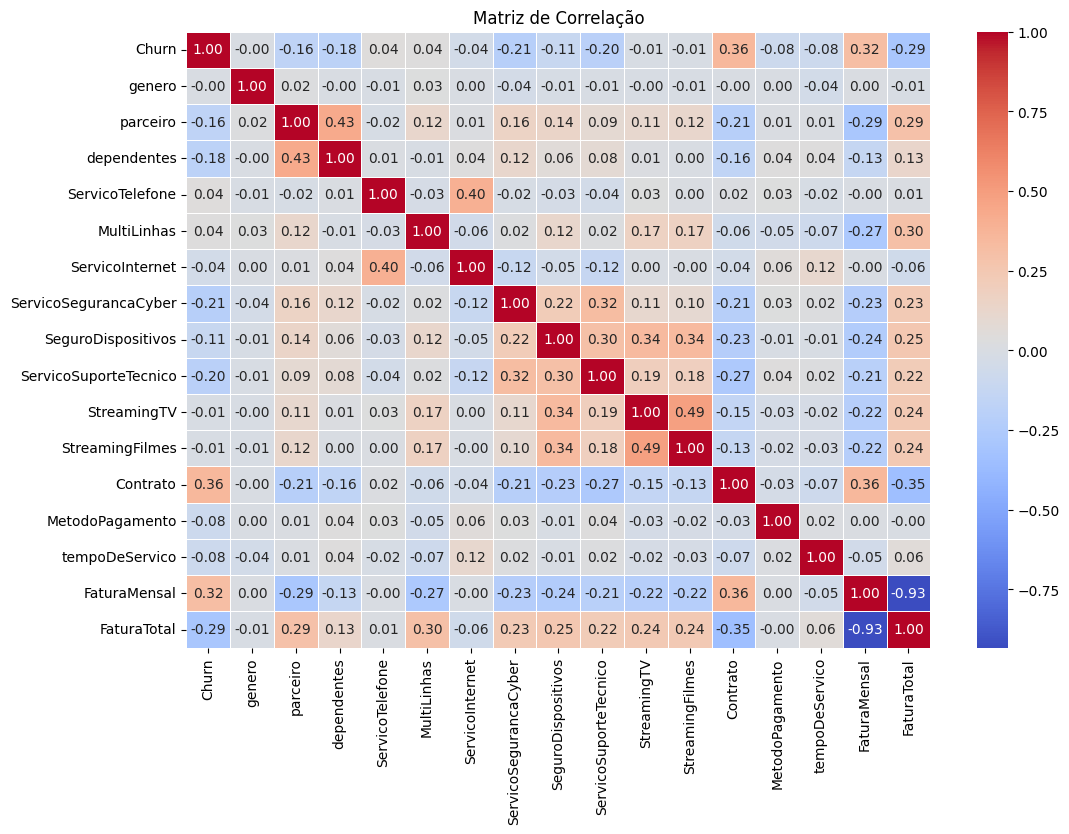

In [ ]:
# Calcular a matriz de correlação
correlation_matrix = sampled_df.corr()

# Plotar a matriz de correlação usando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

###Testes

In [ ]:
# Separar variável alvo e features
X = sampled_df[['genero', 'ServicoInternet','Contrato', 'FaturaMensal','MetodoPagamento' , 'tempoDeServico', 'SeguroDispositivos', 'StreamingTV', 'StreamingFilmes',
'FaturaTotal', 'parceiro', 'dependentes','MultiLinhas','ServicoSegurancaCyber','ServicoSuporteTecnico', 'ServicoTelefone']]

y = sampled_df['Churn']

In [ ]:
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Dividindo os dados em conjuntos de teste (10%) e o restante (90%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Dividindo o X_temp em três conjuntos de treinamento de tamanhos iguais
X_train1, X_temp, y_train1, y_temp = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=42)
X_train2, X_train3, y_train2, y_train3 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_trains = [X_train1, X_train2, X_train3]
y_trains = [y_train1, y_train2, y_train3]

# Treinando e avaliando modelos
for i, (X_t, y_t) in enumerate(zip(X_trains, y_trains)):
    # Usamos um modelo polinomial de grau 2 como exemplo
    model = Pipeline([("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
                      ("linear_regression", LinearRegression())])
    model.fit(X_t, y_t)

    train_error = mean_squared_error(y_t, model.predict(X_t))
    test_error = mean_squared_error(y_test, model.predict(X_test))

    print(f"Subconjunto de treinamento {i+1} (Tamanho {len(X_t)}):")
    print(f"Erro de treinamento: {train_error:.2f}")
    print(f"Erro de teste: {test_error:.2f}\n")

Subconjunto de treinamento 1 (Tamanho 667):
Erro de treinamento: 0.14
Erro de teste: 15.13

Subconjunto de treinamento 2 (Tamanho 667):
Erro de treinamento: 0.12
Erro de teste: 116.00

Subconjunto de treinamento 3 (Tamanho 667):
Erro de treinamento: 0.13
Erro de teste: 9.35



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.1/0.5), random_state=42)

##3. Treinamento do modelo

####Funções

In [ ]:
# Função que cria e retorna um modelo de rede neural
def create_model(neurons1=128, neurons2=64, activation_function='relu'):

    # Inicializando o modelo sequencial
    model = Sequential()

    # 'input_dim' especifica o número de características de entrada
    model.add(Dense(neurons1, input_dim=X_train.shape[1], activation=activation_function))

    # Adicionando a segunda camada oculta com o número de neurônios especificado (neurons2)
    model.add(Dense(neurons2, activation=activation_function))

    # Adicionando a terceira camada oculta com 128 neurônios
    model.add(Dense(128, activation=activation_function))

    # Adicionando a camada de saída com 10 neurônios (para um problema de classificação de 10 classes)
    model.add(Dense(10, activation='softmax'))

    # Compilando o modelo - especificando o otimizador, a função de perda e a métrica de avaliação
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def metricas_classificacao(y_real, y_pred):
    # Calcular métricas
    metrics = {
        "Acurácia": accuracy_score(y_real, y_pred),
        "Precisão (macro)": precision_score(y_real, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_real, y_pred, average='macro'),
        "F1-Score (macro)": f1_score(y_real, y_pred, average='macro')
    }

    # Printar métricas
    for key, value in metrics.items():
        print(f"{key}: {value}")

    # Calcular a Matriz de Confusão
    confusion_mat = confusion_matrix(y_real, y_pred)

    # Printar Matriz de Confusão
    print("Matriz de Confusão:")
    sns.heatmap(confusion_mat, annot=True, cmap='YlGnBu', fmt='g')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

    return metrics

                  Feature  Importance
3            FaturaMensal    0.201631
5          tempoDeServico    0.197347
9             FaturaTotal    0.173386
2                Contrato    0.101330
1         ServicoInternet    0.054567
4         MetodoPagamento    0.053398
0                  genero    0.033251
14  ServicoSuporteTecnico    0.025251
13  ServicoSegurancaCyber    0.025141
12            MultiLinhas    0.024520
11            dependentes    0.021067
6      SeguroDispositivos    0.020845
8         StreamingFilmes    0.020758
7             StreamingTV    0.020658
10               parceiro    0.020579
15        ServicoTelefone    0.006272


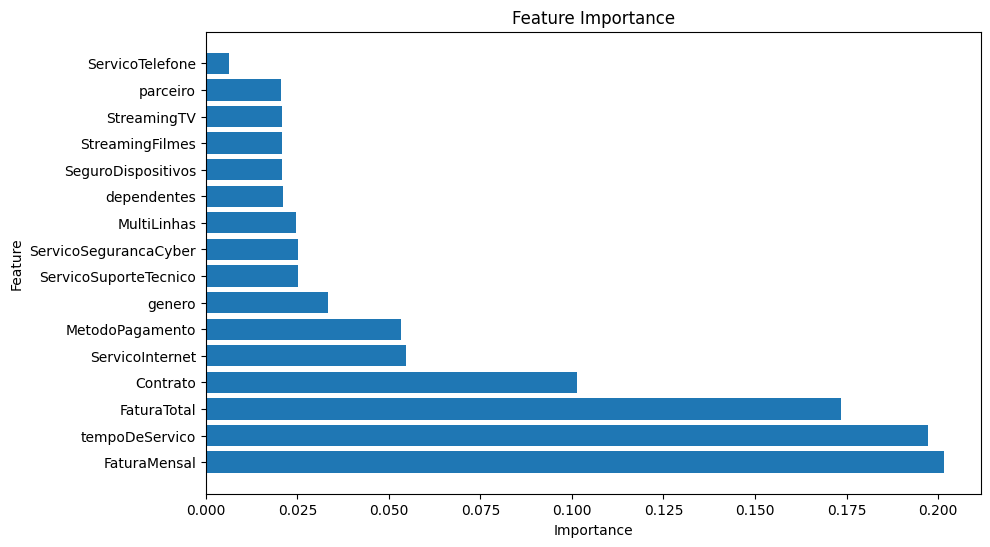

In [ ]:
# Treinar o modelo
model = RandomForestClassifier()
model.fit(X, y)

# Obter a importância das características
feature_importance = model.feature_importances_

# Criar um DataFrame com a importância das características
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Classificar o DataFrame pela importância das características
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Exibir a matriz de importância das características
print(feature_importance_df)

# Plotar a matriz de importância das características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

####Classificações

##### Ponto de Controle 2

Logistic Regression: Accuracy = 0.7528089887640449
Decision Tree: Accuracy = 0.6786516853932584
Random Forest: Accuracy = 0.7460674157303371
SVM: Accuracy = 0.7528089887640449
Gradient Boosting: Accuracy = 0.755056179775281


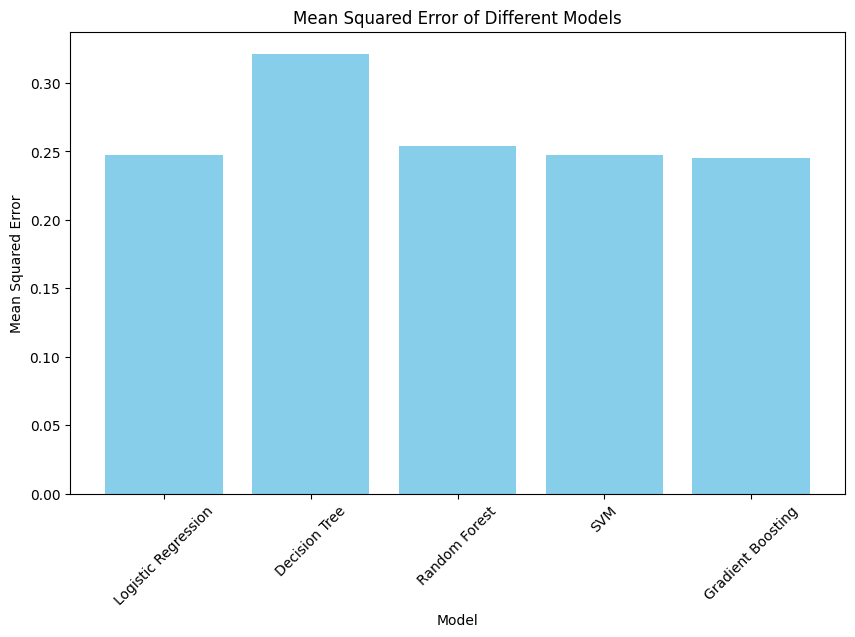

In [ ]:
# Inicializar os modelos
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Inicializar uma lista para armazenar os MSE de cada modelo
mse_scores = []

# Treinar e avaliar os modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {accuracy}")
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), mse_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Different Models')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Supondo que você escolheu o modelo Random Forest como o melhor
best_model = SVC()

# Treinar o modelo selecionado na base de dados completa
best_model.fit(X, y)

# Avaliar o modelo
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the selected model: {accuracy}")

Accuracy of the selected model: 0.7910112359550562


In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Valores para o parâmetro C

def calculate_bias_variance(models, X_train, X_test, y_train, y_test):
    biases, variances, errors = [], [], []
    for C in C_values:
        model = SVC(C=C, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Calculando bias e variance
        bias = np.mean((predictions - y_test) ** 2)
        variance = np.var(predictions)
        error = mean_squared_error(y_test, predictions)

        biases.append(bias)
        variances.append(variance)
        errors.append(error)
    return biases, variances, errors

biases, variances, errors = calculate_bias_variance(models, X_train, X_test, y_train, y_test)

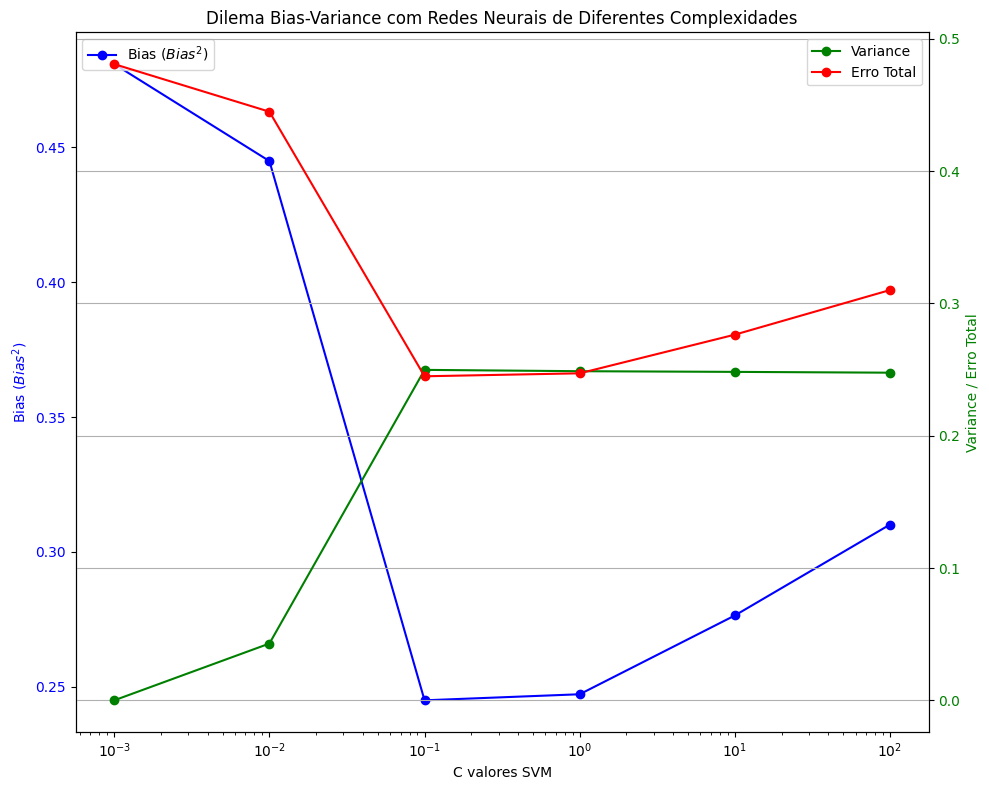

In [ ]:
plt.figure(figsize=(10, 8))

# Criando um eixo para bias
ax1 = plt.gca()
ax1.plot(C_values, biases, label='Bias ($Bias^2$)', marker='o', color='blue')
ax1.set_xlabel('C valores SVM')
ax1.set_ylabel('Bias ($Bias^2$)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Criando um segundo eixo para variância e erro total
ax2 = ax1.twinx()
ax2.plot(C_values, variances, label='Variance', marker='o', color='green')
ax2.plot(C_values, errors, label='Erro Total', marker='o', color='red')
ax2.set_ylabel('Variance / Erro Total', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Dilema Bias-Variance com Redes Neurais de Diferentes Complexidades')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xscale('log')
plt.xlabel("C")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
optimal_model = SVC(C=0.1, random_state=42)
optimal_model.fit(X_train, y_train)

train_accuracy = optimal_model.score(X_train, y_train)
test_accuracy = optimal_model.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.7369308600337268
Test Accuracy: 0.755056179775281


FITING PROPLEMAS

##### Resto

In [ ]:
# Função para encontrar os melhores parâmetros usando Grid Search
def encontrar_melhores_parametros(modelo, parametros, X_train, y_train):
    grid_search = GridSearchCV(modelo, parametros, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

# Random Forest
parametros_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [0, 42]
}

melhores_parametros_rf = encontrar_melhores_parametros(RandomForestClassifier(), parametros_rf, X_train, y_train)
modelo_rf = RandomForestClassifier(**melhores_parametros_rf)
modelo_rf.fit(X_train, y_train)  # Ajuste do modelo aos dados de treinamento
y_pred_rf = modelo_rf.predict(X_test)

# Avaliação do desempenho do Random Forest
print("Random Forest:")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rf))

# Support Vector Classifier (SVC)
parametros_svc = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale'],
    'random_state': [42]
}

melhores_parametros_svc = encontrar_melhores_parametros(SVC(), parametros_svc, X_train, y_train)
modelo_svc = SVC(**melhores_parametros_svc)
modelo_svc.fit(X_train, y_train)  # Ajuste do modelo aos dados de treinamento
y_pred_svc = modelo_svc.predict(X_test)

# Avaliação do desempenho do SVC
print("\nSupport Vector Classifier (SVC):")
print("Acurácia:", accuracy_score(y_test, y_pred_svc))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_svc))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_svc))

# AdaBoostClassifier
parametros_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'random_state': [0, 42]
}

melhores_parametros_adaboost = encontrar_melhores_parametros(AdaBoostClassifier(), parametros_adaboost, X_train, y_train)
modelo_adaboost = AdaBoostClassifier(**melhores_parametros_adaboost)
modelo_adaboost.fit(X_train, y_train)  # Ajuste do modelo aos dados de treinamento
y_pred_adaboost = modelo_adaboost.predict(X_test)

# Avaliação do desempenho do AdaBoostClassifier
print("\nAdaBoostClassifier:")
print("Acurácia:", accuracy_score(y_test, y_pred_adaboost))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_adaboost))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_adaboost))

####Rede Neural

In [ ]:
# Criando uma rede neural simples
model = Sequential()
model.add(Dense(6, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compilando e treinando o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

In [ ]:
weights_first_layer = model.layers[0].get_weights()[0]
print("Pesos da primeira camada:\n", weights_first_layer)

In [ ]:
weights_first_layer.shape

In [ ]:
# Definindo hiperparâmetros para uma rede neural
learning_rate = 0.01
batch_size = 1000
epochs = 5000
number_of_neurons_layer1 = 256
number_of_neurons_layer2 = 128
number_of_neurons_layer3 = 256
activation_function = 'relu'

# Criando um modelo usando os hiperparâmetros
model = Sequential()
model.add(Dense(number_of_neurons_layer1, input_dim=X_train.shape[1], activation=activation_function))
model.add(Dense(number_of_neurons_layer2, activation=activation_function))
model.add(Dense(number_of_neurons_layer3, activation=activation_function))
model.add(Dense(10, activation='softmax'))

# Treinando o modelo usando os hiperparâmetros
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# Criando uma instância do KerasClassifier com a função de criação do modelo e especificando 20 épocas
model_for_grid = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)

# Definindo a grade de hiperparâmetros que queremos testar
param_grid = {
    'neurons1': [8,16,32,64,86],                          # diferentes quantidades de neurônios para a primeira camada
    'neurons2': [8,16,32,64,86],                          # diferentes quantidades de neurônios para a segunda camada
    'activation_function': ['relu', 'tanh']           # diferentes funções de ativação
}

# Configurando o GridSearchCV com o modelo, a grade de parâmetros, e outras opções
grid = GridSearchCV(estimator=model_for_grid, param_grid=param_grid, n_jobs=-1, cv=3)

# Iniciando a busca pelos melhores hiperparâmetros usando o conjunto de treinamento
grid_result = grid.fit(X_train, y_train)

# Imprimindo os melhores hiperparâmetros encontrados
print(f"Melhores parâmetros: {grid_result.best_params_}")

In [ ]:
best_model = create_model(neurons1=32, neurons2=86, activation_function='relu')
best_model.fit(X_train, y_train, epochs=20, verbose = 0)
y_pred = np.argmax(best_model.predict(X_test), axis=1)
metricas = metricas_classificacao(y_test, y_pred)

In [ ]:
model = create_model(neurons1=64, neurons2=64, activation_function='tanh')
model.fit(X_train, y_train, epochs=20, verbose = 0)
y_pred = np.argmax(model.predict(X_test), axis=1)
metricas = metricas_classificacao(y_test, y_pred)

In [ ]:
# Definindo o espaço de hiperparâmetros
param_dist = {
    'neurons1': [8,16,32, 64,84],
    'neurons2': [8,16,32, 64,84],
    'activation_function': ['relu', 'tanh', 'softmax']}

model_for_grid = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)

# Configurando o RandomizedSearchCV com 10 iterações
random_search = RandomizedSearchCV(estimator=model_for_grid, param_distributions=param_dist, n_iter=10, n_jobs=-1, cv=3)

# Iniciando a busca pelos melhores hiperparâmetros usando o conjunto de treinamento
random_result = random_search.fit(X_train, y_train)

# Imprimindo os melhores hiperparâmetros encontrados
print(f"Melhores parâmetros usando RandomizedSearchCV: {random_result.best_params_}")

In [ ]:
model = create_model(neurons1=64, neurons2=84, activation_function='relu')
model.fit(X_train, y_train, epochs=20, verbose = 0)
y_pred = np.argmax(model.predict(X_test), axis=1)
metricas = metricas_classificacao(y_test, y_pred)

In [ ]:
# Definindo a função objetivo que queremos otimizar.
def objective_function(neurons1, neurons2, activation_index):

    # Mapeia os índices para suas respectivas funções de ativação.
    activation_functions = ['relu', 'tanh']
    activation_function = activation_functions[int(activation_index)]

    # Cria e compila o modelo usando os hiperparâmetros fornecidos.
    model = create_model(int(neurons1), int(neurons2), activation_function)

    # Treina o modelo e obtém o histórico de treinamento.
    history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_split=0.2)

    # Obtém a acurácia de validação da última época.
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

# Definindo os limites dos hiperparâmetros para a otimização bayesiana.
pbounds = {
    'neurons1': (16, 20),
    'neurons2': (10, 200),
    'activation_index': (0.5, 1.0)
}

# Inicializa o otimizador bayesiano com a função objetivo e os limites dos hiperparâmetros.
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42
)

# Executa a otimização bayesiana.
optimizer.maximize(init_points=5, n_iter=20)

# Exibe os melhores hiperparâmetros encontrados.
print(f"Melhores parâmetros usando otimização bayesiana: {optimizer.max['params']}")

####XGB

In [ ]:
def encontrar_melhores_parametros(modelo, parametros, X_train, y_train):
    grid_search = GridSearchCV(modelo, parametros, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

# XG Boost
parametros_xgb = {
    'n_estimators': [500],
    'max_depth': [10, 20, 30, 40],
    'enable_categorical' : [True],
    'max_leaves': [10, 20 , 30 , 40],
    'learning_rate': [0.1, 0.01, 0.001],
    'random_state': [0, 42]
}

melhores_parametros_xgb = encontrar_melhores_parametros(xgb.XGBClassifier(), parametros_xgb, X_train, y_train)
modelo_xgb = xgb.XGBClassifier(**melhores_parametros_xgb)
modelo_xgb.fit(X_train, y_train)  # Ajuste do modelo aos dados de treinamento
y_pred_xgb = modelo_xgb.predict(X_test)
metricas = metricas_classificacao(y_test, y_pred_xgb)

# Avaliação do desempenho do XG Boost
print("XGB:")
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_xgb))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_xgb))

####LightGBM

In [ ]:
def LightGBM(df):
  df_modelo = df.copy()

  # Separar variável alvo e features
  X = df_modelo[['genero', 'ServicoInternet','Contrato', 'FaturaMensal','MetodoPagamento' , 'tempoDeServico', 'SeguroDispositivos', 'StreamingTV', 'StreamingFilmes',
  'FaturaTotal', 'parceiro', 'dependentes','MultiLinhas','ServicoSegurancaCyber','ServicoSuporteTecnico', 'ServicoTelefone']]

  y = df_modelo['Churn']

  obj_feat = list(X.select_dtypes(include='object').columns)
  for feature in obj_feat:
      X[feature] = X[feature].astype('category')

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

  lgbm = lgb.LGBMClassifier()

  lgbm.fit(X_train, y_train)

  y_pred = lgbm.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print("Acurácia do modelo:", accuracy)

  lgb.plot_importance(lgbm, importance_type='split', title='Feature Importance (Split)')
  plt.show()

  lgb.plot_importance(lgbm, importance_type='gain', title='Feature Importance (Gain)')
  plt.show()

LightGBM(sampled_df)

In [ ]:
def LightGBM_tuned(df):

    warnings.filterwarnings("ignore")

    df_modelo = df.copy()

    # Separar variável alvo e features
    X = df_modelo[['genero', 'ServicoInternet','Contrato', 'FaturaMensal','MetodoPagamento' , 'tempoDeServico', 'SeguroDispositivos', 'StreamingTV', 'StreamingFilmes',
  'FaturaTotal', 'parceiro', 'dependentes','MultiLinhas','ServicoSegurancaCyber','ServicoSuporteTecnico', 'ServicoTelefone']]

    y = df_modelo['Churn']

    obj_feat = list(X.select_dtypes(include='object').columns)

    for feature in obj_feat:
      X[feature] = X[feature].astype('category')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    gridParams = {
        'learning_rate': [0.2],
        'num_leaves': [90, 200],
        'boosting_type': ['gbdt'],
        'objective': ['binary'],
        'max_depth': [6,8],
        'random_state': [501],
        'colsample_bytree': [0.5, 0.7],
        'subsample': [0.5, 0.7],
        'min_split_gain': [0.01],
        'min_data_in_leaf': [10],
        'metric': ['acc']
    }

    lgbm = lgb.LGBMClassifier()

    # modelling
    grid = RandomizedSearchCV(lgbm, gridParams, verbose=1, cv=10, n_jobs=-1, n_iter=5)  # Ajuste n_iter conforme necessário
    grid.fit(X_train, y_train)

    print("Melhores Parâmetros:", grid.best_params_)

    y_pred = grid.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Acurácia do modelo:", accuracy)

    lgb.plot_importance(grid.best_estimator_, importance_type='split', title='Feature Importance (Split)')
    plt.show()

    lgb.plot_importance(grid.best_estimator_, importance_type='gain', title='Feature Importance (Gain)')
    plt.show()

LightGBM_tuned(sampled_df)

####H2O

In [ ]:
h2o.init()

train_frame = h2o.H2OFrame(sampled_df)

X = ['genero', 'ServicoInternet','Contrato', 'FaturaMensal','MetodoPagamento' , 'tempoDeServico', 'SeguroDispositivos', 'StreamingTV', 'StreamingFilmes',
  'FaturaTotal', 'parceiro', 'dependentes','MultiLinhas','ServicoSegurancaCyber','ServicoSuporteTecnico']
y = 'Churn'

train_frame['Churn'] = train_frame['Churn'].asfactor()

aml = H2OAutoML(max_runtime_secs=1000, seed=42)
aml.train(x=X, y=y, training_frame=train_frame, )

lb = aml.leaderboard
print(lb)

best_model = aml.leader

In [ ]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb

In [ ]:
best_model.gains_lift_plot()

In [ ]:
best_model.accuracy()[0][1]

In [ ]:
best_model.confusion_matrix(metrics='accuracy')

In [ ]:
perf = best_model.model_performance()
perf.plot(type = "roc")

In [ ]:
best_model.model_performance()

In [ ]:
best_model.predict(train_frame)

In [ ]:
# Fazer previsões no conjunto de dados original
y_pred = best_model.predict(train_frame)

y_pred = y_pred.as_data_frame()['predict']

# Converter as previsões para strings
y_pred = y_pred.astype(str)

# Obter os rótulos reais
y_test = sampled_df['Churn'].astype(str)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

##Resultados

In [ ]:
# Fazer previsões no conjunto de dados original
y_pred = best_model.predict(train_frame)
y_pred = y_pred.as_data_frame()['predict']

# Converter as previsões para strings
y_pred = y_pred.astype(str)

# Obter os rótulos reais
y_test = sampled_df['Churn'].astype(str)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

# Gerar e imprimir a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Visualizar a matriz de confusão usando seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()